# MobileNetV2 for PneumoniaMNIST
Fine-tuning a pretrained **MobileNetV2** on the PneumoniaMNIST binary classification dataset (Normal vs Pneumonia).
Includes full metrics: Accuracy, Precision, Recall, F1, Specificity, Sensitivity, MCC, AUC.


In [10]:
!pip install timm medmnist scikit-learn matplotlib seaborn


In [11]:
import os
import math
import time
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import timedelta
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchinfo import summary
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix, classification_report
)
import medmnist
from medmnist import PneumoniaMNIST, INFO


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

info = INFO['pneumoniamnist']
print("Task:", info['task'])
print("Classes:", info['label'])
NUM_CLASSES = len(info['label'])
print("Num classes:", NUM_CLASSES)


Using device: cpu
Task: binary-class
Classes: {'0': 'normal', '1': 'pneumonia'}
Num classes: 2


## Data Transforms
PneumoniaMNIST images are 28×28 grayscale — upsampled to 224×224 and converted to 3-channel RGB.

In [13]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),   # ← move to TOP
    transforms.Resize((256, 256)),
   
  
  
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),   # ← move to TOP
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [14]:
BATCH_SIZE = 64

train_ds = PneumoniaMNIST(split='train', transform=train_transform, download=True)
val_ds   = PneumoniaMNIST(split='val',   transform=val_test_transform, download=True)
test_ds  = PneumoniaMNIST(split='test',  transform=val_test_transform, download=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train size : {len(train_ds)}")
print(f"Val   size : {len(val_ds)}")
print(f"Test  size : {len(test_ds)}")


Train size : 4708
Val   size : 524
Test  size : 624


## Model: MobileNetV2 (Pretrained)
Pretrained on ImageNet-1K. Final classifier replaced for binary output.

In [15]:
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# MobileNetV2 classifier: Sequential(Dropout, Linear(1280, 1000))
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)

model = model.to(device)

dummy = torch.zeros(2, 3, 224, 224).to(device)
with torch.no_grad():
    out = model(dummy)
print("Output shape:", out.shape)  # [2, 2]

summary(model, input_size=(1, 3, 224, 224),
        col_names=("input_size", "output_size", "num_params"), depth=3)


Output shape: torch.Size([2, 2])


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #
MobileNetV2                                        [1, 3, 224, 224]          [1, 2]                    --
├─Sequential: 1-1                                  [1, 3, 224, 224]          [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                   [1, 3, 224, 224]          [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 3, 224, 224]          [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         [1, 32, 112, 112]         64
│    │    └─ReLU6: 3-3                             [1, 32, 112, 112]         [1, 32, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 32, 112, 112]         [1, 16, 112, 112]         --
│    │    └─Sequential: 3-4                        [1, 32, 112, 112]         [1, 16, 112, 112]         896
│    └─InvertedResidual: 2-3           

In [16]:
def custom_metrics(y_pred, y_true, loss):
    y_prob         = torch.softmax(y_pred, dim=1)
    y_pred_classes = torch.argmax(y_prob, dim=1)

    y_true_np = y_true.cpu().numpy()
    y_pred_np = y_pred_classes.cpu().numpy()
    y_prob_np = y_prob.cpu().numpy()

    accuracy  = accuracy_score(y_true_np, y_pred_np)
    precision = precision_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
    recall    = recall_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
    f1        = f1_score(y_true_np, y_pred_np, average='weighted', zero_division=0)

    cm = confusion_matrix(y_true_np, y_pred_np)
    num_cls = cm.shape[0]
    specificities, sensitivities = [], []
    for i in range(num_cls):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - tp - fn - fp
        specificities.append(tn / (tn + fp) if (tn + fp) > 0 else 0.0)
        sensitivities.append(tp / (tp + fn) if (tp + fn) > 0 else 0.0)
    specificity = float(np.mean(specificities))
    sensitivity = float(np.mean(sensitivities))

    mcc = matthews_corrcoef(y_true_np, y_pred_np)

    auc_scores = []
    for cls_i in range(num_cls):
        bin_true = (y_true_np == cls_i).astype(np.float32)
        try:
            auc_scores.append(roc_auc_score(bin_true, y_prob_np[:, cls_i]))
        except ValueError:
            auc_scores.append(0.0)
    auc_avg = float(np.mean(auc_scores))

    return {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }


## Training Setup
- **Loss**: CrossEntropyLoss with label smoothing 0.1
- **Optimizer**: AdamW, weight decay 1e-2
- **Scheduler**: Cosine annealing with linear warmup
- **Gradient clipping**: max norm 1.0

In [17]:
num_epochs    = 25
initial_lr    = 3e-4
warmup_epochs = 3

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=1e-2)

def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    progress = (epoch - warmup_epochs) / max(1, num_epochs - warmup_epochs)
    return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)


In [18]:
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]

train_metrics_history = {m: [] for m in metric_names}
val_metrics_history   = {m: [] for m in metric_names}

total_training_time   = 0.0
total_validation_time = 0.0
best_val_acc          = 0.0

for epoch in range(num_epochs):

    # ── Train ────────────────────────────────────────────────────
    model.train()
    t0         = time.time()
    total_loss = 0.0
    all_preds  = []
    all_tgts   = []

    for data, targets in tqdm(train_loader, desc=f"Train [{epoch+1}/{num_epochs}]"):
        data    = data.to(device)
        targets = targets.squeeze(1).long().to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss    = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        all_preds.extend(outputs.detach().cpu().numpy())
        all_tgts.extend(targets.detach().cpu().numpy())

    total_training_time += time.time() - t0

    train_metrics = custom_metrics(
        torch.tensor(np.array(all_preds)),
        torch.tensor(np.array(all_tgts)),
        total_loss / len(train_loader)
    )
    for m in metric_names:
        train_metrics_history[m].append(train_metrics[m])
    print(f"[Train] Ep {epoch+1:2d} | " + " | ".join(f"{k}: {v:.4f}" for k, v in train_metrics.items()))

    # ── Validate ─────────────────────────────────────────────────
    model.eval()
    t0         = time.time()
    total_loss = 0.0
    all_preds  = []
    all_tgts   = []

    with torch.no_grad():
        for data, targets in tqdm(val_loader, desc="Validate"):
            data    = data.to(device)
            targets = targets.squeeze(1).long().to(device)
            outputs = model(data)
            total_loss += criterion(outputs, targets).item()
            all_preds.extend(outputs.detach().cpu().numpy())
            all_tgts.extend(targets.detach().cpu().numpy())

    total_validation_time += time.time() - t0

    val_metrics = custom_metrics(
        torch.tensor(np.array(all_preds)),
        torch.tensor(np.array(all_tgts)),
        total_loss / len(val_loader)
    )
    for m in metric_names:
        val_metrics_history[m].append(val_metrics[m])
    print(f"[Val]   Ep {epoch+1:2d} | " + " | ".join(f"{k}: {v:.4f}" for k, v in val_metrics.items()))

    if val_metrics['accuracy'] > best_val_acc:
        best_val_acc = val_metrics['accuracy']
        torch.save(model.state_dict(), '/kaggle/working/best_mobilenetv2_pneumonia.pth')
        print(f"  ✓ Best model saved  (val_acc={best_val_acc:.4f})")

    scheduler.step()
    print(f"  LR = {scheduler.get_last_lr()[0]:.2e}\n")

print(f"Total Training Time  : {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")
print(f"Avg Train Time/Epoch : {str(timedelta(seconds=total_training_time / num_epochs))}")
print(f"Avg Val   Time/Epoch : {str(timedelta(seconds=total_validation_time / num_epochs))}")


Train [1/25]: 100%|██████████| 74/74 [10:11<00:00,  8.26s/it]


[Train] Ep  1 | loss: 0.3283 | accuracy: 0.9195 | precision: 0.9219 | recall: 0.9195 | f1_score: 0.9204 | specificity: 0.9063 | sensitivity: 0.9063 | mcc: 0.7952 | auc: 0.9740


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:14<00:00,  1.60s/it]


[Val]   Ep  1 | loss: 0.2740 | accuracy: 0.9561 | precision: 0.9572 | recall: 0.9561 | f1_score: 0.9565 | specificity: 0.9511 | sensitivity: 0.9511 | mcc: 0.8877 | auc: 0.9943
  ✓ Best model saved  (val_acc=0.9561)
  LR = 2.00e-04



Train [2/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [2/25]: 100%|██████████| 74/74 [11:25<00:00,  9.26s/it]


[Train] Ep  2 | loss: 0.2547 | accuracy: 0.9715 | precision: 0.9714 | recall: 0.9715 | f1_score: 0.9715 | specificity: 0.9601 | sensitivity: 0.9601 | mcc: 0.9253 | auc: 0.9954


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:15<00:00,  1.74s/it]


[Val]   Ep  2 | loss: 0.2927 | accuracy: 0.9504 | precision: 0.9566 | recall: 0.9504 | f1_score: 0.9515 | specificity: 0.9617 | sensitivity: 0.9617 | mcc: 0.8816 | auc: 0.9954
  LR = 3.00e-04



Train [3/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [3/25]: 100%|██████████| 74/74 [11:25<00:00,  9.27s/it]


[Train] Ep  3 | loss: 0.2355 | accuracy: 0.9851 | precision: 0.9851 | recall: 0.9851 | f1_score: 0.9851 | specificity: 0.9776 | sensitivity: 0.9776 | mcc: 0.9610 | auc: 0.9980


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:14<00:00,  1.63s/it]


[Val]   Ep  3 | loss: 0.3383 | accuracy: 0.9237 | precision: 0.9411 | recall: 0.9237 | f1_score: 0.9265 | specificity: 0.9486 | sensitivity: 0.9486 | mcc: 0.8319 | auc: 0.9940
  LR = 3.00e-04



Train [4/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [4/25]: 100%|██████████| 74/74 [11:21<00:00,  9.21s/it]


[Train] Ep  4 | loss: 0.2318 | accuracy: 0.9870 | precision: 0.9870 | recall: 0.9870 | f1_score: 0.9870 | specificity: 0.9805 | sensitivity: 0.9805 | mcc: 0.9660 | auc: 0.9987


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:13<00:00,  1.45s/it]


[Val]   Ep  4 | loss: 0.2554 | accuracy: 0.9695 | precision: 0.9715 | recall: 0.9695 | f1_score: 0.9699 | specificity: 0.9746 | sensitivity: 0.9746 | mcc: 0.9240 | auc: 0.9981
  ✓ Best model saved  (val_acc=0.9695)
  LR = 2.98e-04



Train [5/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [5/25]: 100%|██████████| 74/74 [11:17<00:00,  9.15s/it]


[Train] Ep  5 | loss: 0.2130 | accuracy: 0.9958 | precision: 0.9957 | recall: 0.9958 | f1_score: 0.9957 | specificity: 0.9936 | sensitivity: 0.9936 | mcc: 0.9889 | auc: 0.9999


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:13<00:00,  1.47s/it]


[Val]   Ep  5 | loss: 0.2485 | accuracy: 0.9676 | precision: 0.9694 | recall: 0.9676 | f1_score: 0.9680 | specificity: 0.9709 | sensitivity: 0.9709 | mcc: 0.9187 | auc: 0.9971
  LR = 2.94e-04



Train [6/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [6/25]: 100%|██████████| 74/74 [11:20<00:00,  9.20s/it]


[Train] Ep  6 | loss: 0.2074 | accuracy: 0.9983 | precision: 0.9983 | recall: 0.9983 | f1_score: 0.9983 | specificity: 0.9978 | sensitivity: 0.9978 | mcc: 0.9956 | auc: 1.0000


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:15<00:00,  1.67s/it]


[Val]   Ep  6 | loss: 0.3519 | accuracy: 0.9179 | precision: 0.9378 | recall: 0.9179 | f1_score: 0.9212 | specificity: 0.9447 | sensitivity: 0.9447 | mcc: 0.8213 | auc: 0.9940
  LR = 2.86e-04



Train [7/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [7/25]: 100%|██████████| 74/74 [11:22<00:00,  9.22s/it]


[Train] Ep  7 | loss: 0.2053 | accuracy: 0.9987 | precision: 0.9987 | recall: 0.9987 | f1_score: 0.9987 | specificity: 0.9986 | sensitivity: 0.9986 | mcc: 0.9967 | auc: 1.0000


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:13<00:00,  1.49s/it]


[Val]   Ep  7 | loss: 0.2825 | accuracy: 0.9599 | precision: 0.9645 | recall: 0.9599 | f1_score: 0.9607 | specificity: 0.9706 | sensitivity: 0.9706 | mcc: 0.9036 | auc: 0.9962
  LR = 2.76e-04



Train [8/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [8/25]: 100%|██████████| 74/74 [11:16<00:00,  9.15s/it]


[Train] Ep  8 | loss: 0.2037 | accuracy: 0.9992 | precision: 0.9992 | recall: 0.9992 | f1_score: 0.9992 | specificity: 0.9986 | sensitivity: 0.9986 | mcc: 0.9978 | auc: 1.0000


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:14<00:00,  1.67s/it]


[Val]   Ep  8 | loss: 0.4405 | accuracy: 0.8740 | precision: 0.9154 | recall: 0.8740 | f1_score: 0.8806 | specificity: 0.9152 | sensitivity: 0.9152 | mcc: 0.7468 | auc: 0.9916
  LR = 2.63e-04



Train [9/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [9/25]: 100%|██████████| 74/74 [11:20<00:00,  9.19s/it]


[Train] Ep  9 | loss: 0.2021 | accuracy: 0.9996 | precision: 0.9996 | recall: 0.9996 | f1_score: 0.9996 | specificity: 0.9994 | sensitivity: 0.9994 | mcc: 0.9989 | auc: 1.0000


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:15<00:00,  1.68s/it]


[Val]   Ep  9 | loss: 0.3390 | accuracy: 0.9256 | precision: 0.9423 | recall: 0.9256 | f1_score: 0.9283 | specificity: 0.9499 | sensitivity: 0.9499 | mcc: 0.8355 | auc: 0.9937
  LR = 2.48e-04



Train [10/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [10/25]: 100%|██████████| 74/74 [11:19<00:00,  9.18s/it]


[Train] Ep 10 | loss: 0.2015 | accuracy: 0.9996 | precision: 0.9996 | recall: 0.9996 | f1_score: 0.9996 | specificity: 0.9994 | sensitivity: 0.9994 | mcc: 0.9989 | auc: 1.0000


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:15<00:00,  1.69s/it]


[Val]   Ep 10 | loss: 0.4016 | accuracy: 0.9179 | precision: 0.9378 | recall: 0.9179 | f1_score: 0.9212 | specificity: 0.9447 | sensitivity: 0.9447 | mcc: 0.8213 | auc: 0.9899
  LR = 2.31e-04



Train [11/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [11/25]: 100%|██████████| 74/74 [11:30<00:00,  9.34s/it]


[Train] Ep 11 | loss: 0.2013 | accuracy: 0.9996 | precision: 0.9996 | recall: 0.9996 | f1_score: 0.9996 | specificity: 0.9992 | sensitivity: 0.9992 | mcc: 0.9989 | auc: 1.0000


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:14<00:00,  1.67s/it]


[Val]   Ep 11 | loss: 0.3518 | accuracy: 0.9332 | precision: 0.9470 | recall: 0.9332 | f1_score: 0.9355 | specificity: 0.9550 | sensitivity: 0.9550 | mcc: 0.8501 | auc: 0.9893
  LR = 2.12e-04



Train [12/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [12/25]: 100%|██████████| 74/74 [11:27<00:00,  9.29s/it]


[Train] Ep 12 | loss: 0.2004 | accuracy: 1.0000 | precision: 1.0000 | recall: 1.0000 | f1_score: 1.0000 | specificity: 1.0000 | sensitivity: 1.0000 | mcc: 1.0000 | auc: 1.0000


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:14<00:00,  1.65s/it]


[Val]   Ep 12 | loss: 0.2932 | accuracy: 0.9618 | precision: 0.9653 | recall: 0.9618 | f1_score: 0.9625 | specificity: 0.9695 | sensitivity: 0.9695 | mcc: 0.9066 | auc: 0.9934
  LR = 1.92e-04



Train [13/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [13/25]: 100%|██████████| 74/74 [11:29<00:00,  9.32s/it]


[Train] Ep 13 | loss: 0.2001 | accuracy: 1.0000 | precision: 1.0000 | recall: 1.0000 | f1_score: 1.0000 | specificity: 1.0000 | sensitivity: 1.0000 | mcc: 1.0000 | auc: 1.0000


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:15<00:00,  1.68s/it]


[Val]   Ep 13 | loss: 0.3338 | accuracy: 0.9332 | precision: 0.9458 | recall: 0.9332 | f1_score: 0.9354 | specificity: 0.9526 | sensitivity: 0.9526 | mcc: 0.8482 | auc: 0.9942
  LR = 1.71e-04



Train [14/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [14/25]: 100%|██████████| 74/74 [11:18<00:00,  9.17s/it]


[Train] Ep 14 | loss: 0.2000 | accuracy: 1.0000 | precision: 1.0000 | recall: 1.0000 | f1_score: 1.0000 | specificity: 1.0000 | sensitivity: 1.0000 | mcc: 1.0000 | auc: 1.0000


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:14<00:00,  1.65s/it]


[Val]   Ep 14 | loss: 0.3005 | accuracy: 0.9485 | precision: 0.9561 | recall: 0.9485 | f1_score: 0.9498 | specificity: 0.9629 | sensitivity: 0.9629 | mcc: 0.8791 | auc: 0.9957
  LR = 1.50e-04



Train [15/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [15/25]: 100%|██████████| 74/74 [11:21<00:00,  9.21s/it]


[Train] Ep 15 | loss: 0.1997 | accuracy: 1.0000 | precision: 1.0000 | recall: 1.0000 | f1_score: 1.0000 | specificity: 1.0000 | sensitivity: 1.0000 | mcc: 1.0000 | auc: 1.0000


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:13<00:00,  1.48s/it]


[Val]   Ep 15 | loss: 0.3115 | accuracy: 0.9485 | precision: 0.9552 | recall: 0.9485 | f1_score: 0.9497 | specificity: 0.9605 | sensitivity: 0.9605 | mcc: 0.8776 | auc: 0.9951
  LR = 1.29e-04



Train [16/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [16/25]: 100%|██████████| 74/74 [11:17<00:00,  9.16s/it]


[Train] Ep 16 | loss: 0.1996 | accuracy: 1.0000 | precision: 1.0000 | recall: 1.0000 | f1_score: 1.0000 | specificity: 1.0000 | sensitivity: 1.0000 | mcc: 1.0000 | auc: 1.0000


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:14<00:00,  1.61s/it]


[Val]   Ep 16 | loss: 0.3171 | accuracy: 0.9408 | precision: 0.9508 | recall: 0.9408 | f1_score: 0.9426 | specificity: 0.9577 | sensitivity: 0.9577 | mcc: 0.8634 | auc: 0.9913
  LR = 1.08e-04



Train [17/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [17/25]: 100%|██████████| 74/74 [11:13<00:00,  9.11s/it]


[Train] Ep 17 | loss: 0.1996 | accuracy: 1.0000 | precision: 1.0000 | recall: 1.0000 | f1_score: 1.0000 | specificity: 1.0000 | sensitivity: 1.0000 | mcc: 1.0000 | auc: 1.0000


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:13<00:00,  1.46s/it]


[Val]   Ep 17 | loss: 0.3002 | accuracy: 0.9561 | precision: 0.9616 | recall: 0.9561 | f1_score: 0.9571 | specificity: 0.9680 | sensitivity: 0.9680 | mcc: 0.8953 | auc: 0.9935
  LR = 8.77e-05



Train [18/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [18/25]: 100%|██████████| 74/74 [11:17<00:00,  9.15s/it]


[Train] Ep 18 | loss: 0.1994 | accuracy: 1.0000 | precision: 1.0000 | recall: 1.0000 | f1_score: 1.0000 | specificity: 1.0000 | sensitivity: 1.0000 | mcc: 1.0000 | auc: 1.0000


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:15<00:00,  1.68s/it]


[Val]   Ep 18 | loss: 0.3316 | accuracy: 0.9370 | precision: 0.9494 | recall: 0.9370 | f1_score: 0.9391 | specificity: 0.9576 | sensitivity: 0.9576 | mcc: 0.8576 | auc: 0.9930
  LR = 6.89e-05



Train [19/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [19/25]: 100%|██████████| 74/74 [11:20<00:00,  9.20s/it]


[Train] Ep 19 | loss: 0.1994 | accuracy: 1.0000 | precision: 1.0000 | recall: 1.0000 | f1_score: 1.0000 | specificity: 1.0000 | sensitivity: 1.0000 | mcc: 1.0000 | auc: 1.0000


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:14<00:00,  1.66s/it]


[Val]   Ep 19 | loss: 0.3187 | accuracy: 0.9427 | precision: 0.9532 | recall: 0.9427 | f1_score: 0.9445 | specificity: 0.9614 | sensitivity: 0.9614 | mcc: 0.8690 | auc: 0.9942
  LR = 5.18e-05



Train [20/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [20/25]: 100%|██████████| 74/74 [11:17<00:00,  9.16s/it]


[Train] Ep 20 | loss: 0.1994 | accuracy: 1.0000 | precision: 1.0000 | recall: 1.0000 | f1_score: 1.0000 | specificity: 1.0000 | sensitivity: 1.0000 | mcc: 1.0000 | auc: 1.0000


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:13<00:00,  1.48s/it]


[Val]   Ep 20 | loss: 0.3002 | accuracy: 0.9580 | precision: 0.9631 | recall: 0.9580 | f1_score: 0.9589 | specificity: 0.9693 | sensitivity: 0.9693 | mcc: 0.8994 | auc: 0.9948
  LR = 3.66e-05



Train [21/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [21/25]: 100%|██████████| 74/74 [11:24<00:00,  9.25s/it]


[Train] Ep 21 | loss: 0.1993 | accuracy: 1.0000 | precision: 1.0000 | recall: 1.0000 | f1_score: 1.0000 | specificity: 1.0000 | sensitivity: 1.0000 | mcc: 1.0000 | auc: 1.0000


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:14<00:00,  1.66s/it]


[Val]   Ep 21 | loss: 0.3257 | accuracy: 0.9408 | precision: 0.9519 | recall: 0.9408 | f1_score: 0.9427 | specificity: 0.9602 | sensitivity: 0.9602 | mcc: 0.8651 | auc: 0.9929
  LR = 2.38e-05



Train [22/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [22/25]: 100%|██████████| 74/74 [11:18<00:00,  9.17s/it]


[Train] Ep 22 | loss: 0.1993 | accuracy: 1.0000 | precision: 1.0000 | recall: 1.0000 | f1_score: 1.0000 | specificity: 1.0000 | sensitivity: 1.0000 | mcc: 1.0000 | auc: 1.0000


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:14<00:00,  1.63s/it]


[Val]   Ep 22 | loss: 0.3197 | accuracy: 0.9408 | precision: 0.9519 | recall: 0.9408 | f1_score: 0.9427 | specificity: 0.9602 | sensitivity: 0.9602 | mcc: 0.8651 | auc: 0.9942
  LR = 1.36e-05



Train [23/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [23/25]: 100%|██████████| 74/74 [11:26<00:00,  9.27s/it]


[Train] Ep 23 | loss: 0.1992 | accuracy: 1.0000 | precision: 1.0000 | recall: 1.0000 | f1_score: 1.0000 | specificity: 1.0000 | sensitivity: 1.0000 | mcc: 1.0000 | auc: 1.0000


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:13<00:00,  1.49s/it]


[Val]   Ep 23 | loss: 0.3232 | accuracy: 0.9408 | precision: 0.9519 | recall: 0.9408 | f1_score: 0.9427 | specificity: 0.9602 | sensitivity: 0.9602 | mcc: 0.8651 | auc: 0.9939
  LR = 6.08e-06



Train [24/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [24/25]: 100%|██████████| 74/74 [11:18<00:00,  9.17s/it]


[Train] Ep 24 | loss: 0.1992 | accuracy: 1.0000 | precision: 1.0000 | recall: 1.0000 | f1_score: 1.0000 | specificity: 1.0000 | sensitivity: 1.0000 | mcc: 1.0000 | auc: 1.0000


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:15<00:00,  1.67s/it]


[Val]   Ep 24 | loss: 0.3324 | accuracy: 0.9370 | precision: 0.9494 | recall: 0.9370 | f1_score: 0.9391 | specificity: 0.9576 | sensitivity: 0.9576 | mcc: 0.8576 | auc: 0.9935
  LR = 1.53e-06



Train [25/25]:   0%|          | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train [25/25]: 100%|██████████| 74/74 [11:28<00:00,  9.30s/it]


[Train] Ep 25 | loss: 0.1993 | accuracy: 1.0000 | precision: 1.0000 | recall: 1.0000 | f1_score: 1.0000 | specificity: 1.0000 | sensitivity: 1.0000 | mcc: 1.0000 | auc: 1.0000


Validate:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validate: 100%|██████████| 9/9 [00:13<00:00,  1.50s/it]


[Val]   Ep 25 | loss: 0.3260 | accuracy: 0.9408 | precision: 0.9519 | recall: 0.9408 | f1_score: 0.9427 | specificity: 0.9602 | sensitivity: 0.9602 | mcc: 0.8651 | auc: 0.9938
  LR = 0.00e+00

Total Training Time  : 4:42:51.947635
Total Validation Time: 0:06:00.581721
Avg Train Time/Epoch : 0:11:18.877905
Avg Val   Time/Epoch : 0:00:14.423269


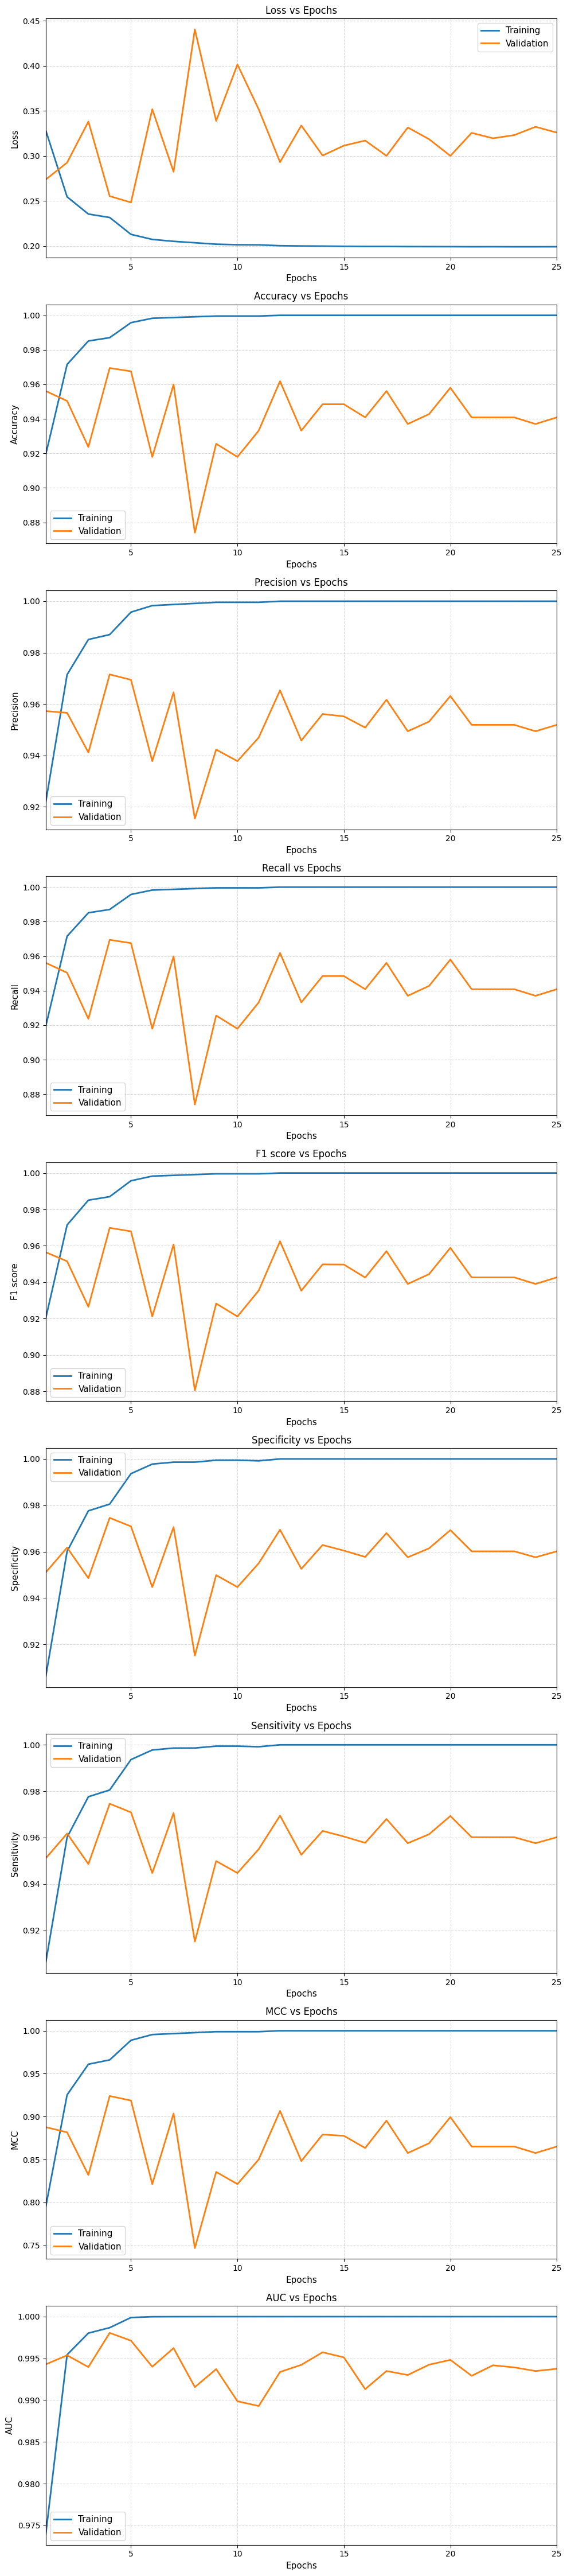

In [19]:
def plot_metrics(train_history, val_history, metric_names):
    num_ep = len(train_history[metric_names[0]])
    fig, axes = plt.subplots(len(metric_names), 1, figsize=(10, 5 * len(metric_names)))
    rng = range(1, num_ep + 1)
    for ax, name in zip(axes, metric_names):
        ax.plot(rng, train_history[name], label="Training",   linewidth=2)
        ax.plot(rng, val_history[name],   label="Validation", linewidth=2)
        ax.legend(fontsize=11)
        ax.set_xlabel("Epochs", fontsize=11)
        label = name.upper() if name in ("auc", "mcc") else name.replace("_", " ").capitalize()
        ax.set_ylabel(label, fontsize=11)
        ax.set_title(f"{label} vs Epochs", fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_ep)
    plt.tight_layout()
    plt.savefig('/kaggle/working/mobilenetv2_training_metrics.png', dpi=150)
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)


## Test Evaluation
Loads the best checkpoint and evaluates on the test set.

In [20]:
model.load_state_dict(torch.load('/kaggle/working/best_mobilenetv2_pneumonia.pth', map_location=device))
model.eval()

total_loss = 0.0
all_preds  = []
all_tgts   = []

with torch.no_grad():
    for data, targets in tqdm(test_loader, desc="Testing"):
        data    = data.to(device)
        targets = targets.squeeze(1).long().to(device)
        outputs = model(data)
        total_loss += criterion(outputs, targets).item()
        all_preds.extend(outputs.detach().cpu().numpy())
        all_tgts.extend(targets.detach().cpu().numpy())

all_preds = np.array(all_preds)
all_tgts  = np.array(all_tgts)

test_metrics = custom_metrics(
    torch.tensor(all_preds),
    torch.tensor(all_tgts),
    total_loss / len(test_loader)
)

print("=" * 40)
print("         TEST RESULTS")
print("=" * 40)
for k, v in test_metrics.items():
    print(f"  {k:14s}: {v:.4f}")
print("=" * 40)


Testing:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Testing: 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]

         TEST RESULTS
  loss          : 0.3478
  accuracy      : 0.9199
  precision     : 0.9243
  recall        : 0.9199
  f1_score      : 0.9182
  specificity   : 0.8983
  sensitivity   : 0.8983
  mcc           : 0.8308
  auc           : 0.9639


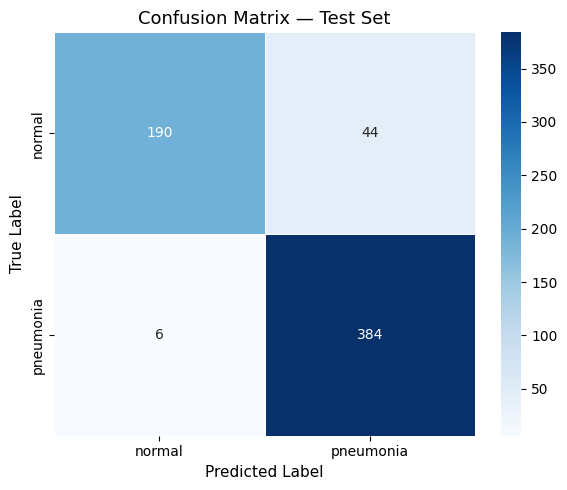


Classification Report:
              precision    recall  f1-score   support

      normal       0.97      0.81      0.88       234
   pneumonia       0.90      0.98      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624



In [21]:
CLASS_NAMES = list(info['label'].values())

y_pred_cls = np.argmax(all_preds, axis=1)
cm = confusion_matrix(all_tgts, y_pred_cls)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, linewidths=0.5)
plt.title('Confusion Matrix — Test Set', fontsize=13)
plt.ylabel('True Label', fontsize=11)
plt.xlabel('Predicted Label', fontsize=11)
plt.tight_layout()
plt.savefig('/kaggle/working/mobilenetv2_confusion_matrix.png', dpi=150)
plt.show()

print("\nClassification Report:")
print(classification_report(all_tgts, y_pred_cls, target_names=CLASS_NAMES))


## Sample Predictions
Visualise 18 test images with predicted vs true labels.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


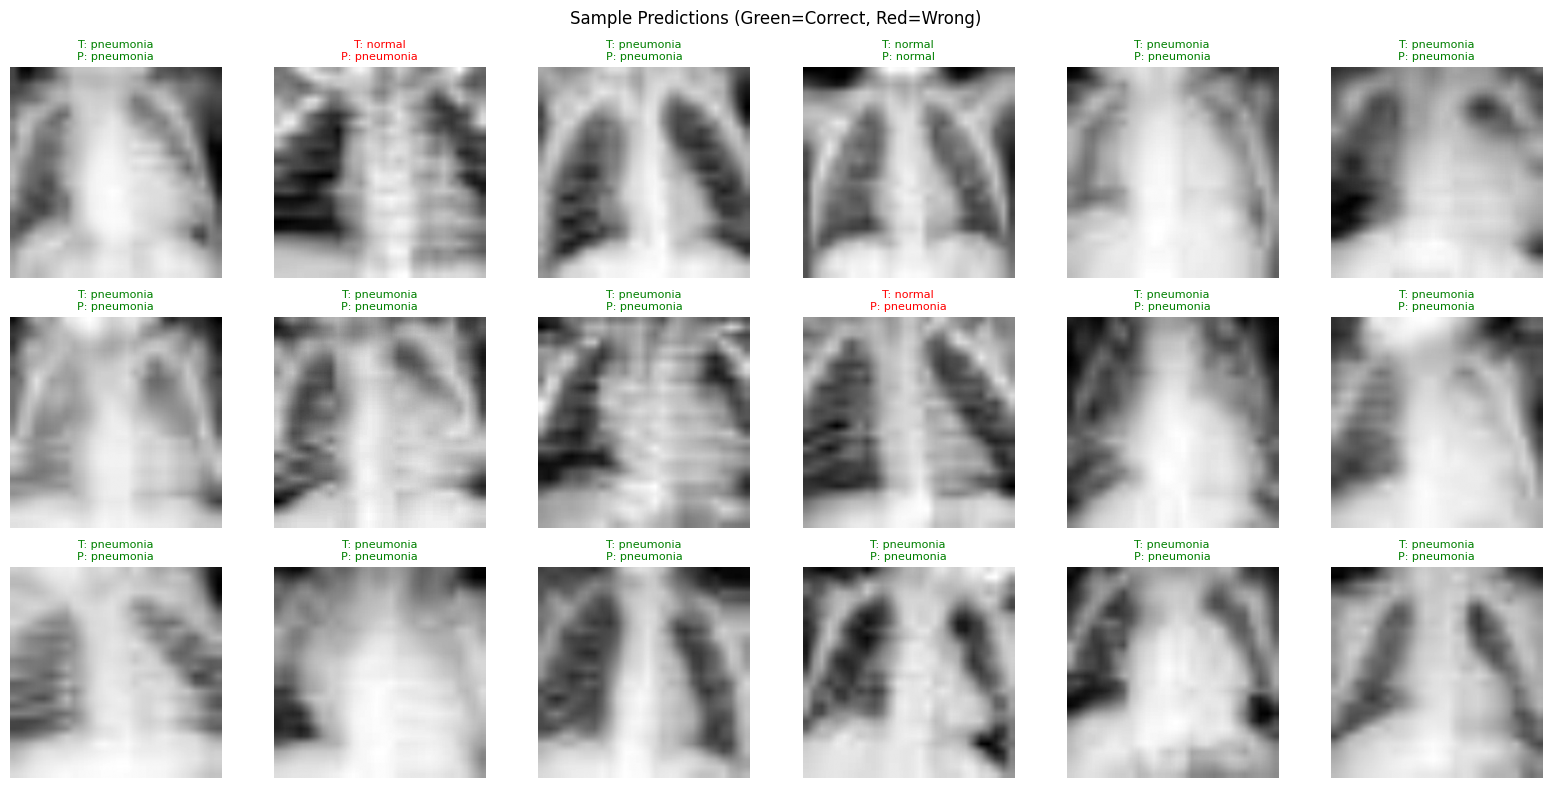

In [22]:
model.eval()
images_shown = 0
fig, axes = plt.subplots(3, 6, figsize=(16, 8))
axes = axes.flatten()

IMAGENET_MEAN_T = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
IMAGENET_STD_T  = torch.tensor(IMAGENET_STD).view(3, 1, 1)

with torch.no_grad():
    for data, targets in test_loader:
        data_dev = data.to(device)
        targets  = targets.squeeze(1).long()
        outputs  = model(data_dev)
        preds    = torch.argmax(torch.softmax(outputs, dim=1), dim=1).cpu()

        for i in range(len(data)):
            if images_shown >= 18:
                break
            img = data[i].cpu() * IMAGENET_STD_T + IMAGENET_MEAN_T
            img = img.permute(1, 2, 0).numpy().clip(0, 1)
            axes[images_shown].imshow(img[:, :, 0], cmap='gray')
            true_lbl = CLASS_NAMES[targets[i].item()]
            pred_lbl = CLASS_NAMES[preds[i].item()]
            color    = 'green' if targets[i] == preds[i] else 'red'
            axes[images_shown].set_title(f"T: {true_lbl}\nP: {pred_lbl}", fontsize=8, color=color)
            axes[images_shown].axis('off')
            images_shown += 1
        if images_shown >= 18:
            break

plt.suptitle('Sample Predictions (Green=Correct, Red=Wrong)', fontsize=12)
plt.tight_layout()
plt.savefig('/kaggle/working/mobilenetv2_sample_preds.png', dpi=150)
plt.show()
